In [184]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

In [185]:
DATSET = 'Data/resized_grayscale_images'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [512,512,256,128,64,32,16] #change depending on CUDA
CHANNELS_IMG = 3 #rgb
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)

In [186]:
def get_loader(image_size): #resizeimages
    trainsform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset = datasets.ImageFolder(root=DATSET, transform=trainsform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

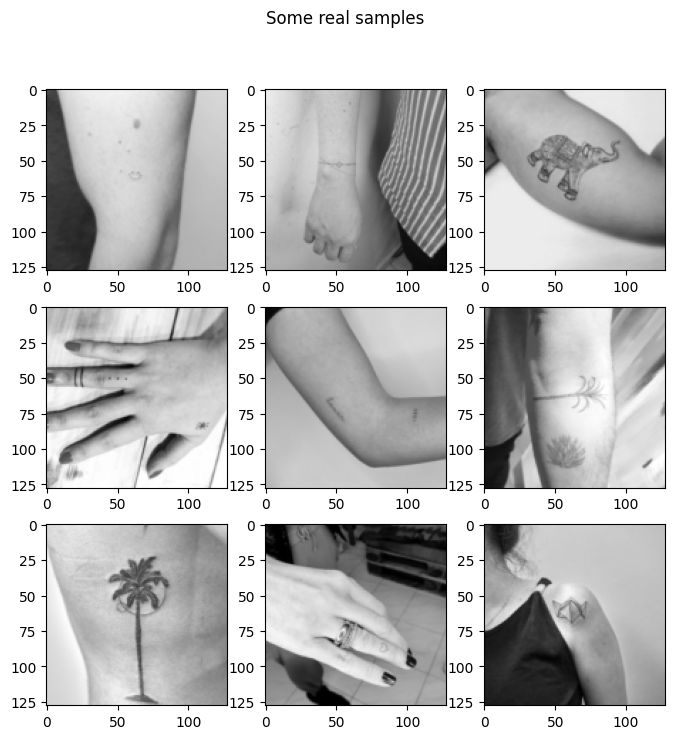

In [187]:
def check_loader(): #checking if data loader works and plot it
    loader,_ = get_loader(128)
    cloth,_  = next(iter(loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1
check_loader() 

In [188]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [189]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias

In [190]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

In [191]:
class MappingNetwork(nn.Module):
    def __init__(self, Z_DIM, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(Z_DIM, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

In [192]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [193]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

In [194]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [195]:
class Generator(nn.Module):
    def __init__(self, Z_DIM, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(Z_DIM, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [196]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [197]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [198]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [199]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [200]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [201]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

In [202]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1


Curent image size: 4
Epoch [1/ 30


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:08<00:00,  2.22s/it, gp=0.256, loss_critic=-62.3]


Epoch [2/ 30


100%|██████████| 4/4 [00:08<00:00,  2.05s/it, gp=0.132, loss_critic=-138]  


Epoch [3/ 30


100%|██████████| 4/4 [00:08<00:00,  2.02s/it, gp=0.279, loss_critic=-266]


Epoch [4/ 30


100%|██████████| 4/4 [00:08<00:00,  2.03s/it, gp=1.37, loss_critic=-408] 


Epoch [5/ 30


100%|██████████| 4/4 [00:08<00:00,  2.03s/it, gp=1.32, loss_critic=-197]


Epoch [6/ 30


100%|██████████| 4/4 [00:08<00:00,  2.02s/it, gp=2.33, loss_critic=-334]


Epoch [7/ 30


100%|██████████| 4/4 [00:08<00:00,  2.09s/it, gp=3.12, loss_critic=-272]


Epoch [8/ 30


100%|██████████| 4/4 [00:08<00:00,  2.14s/it, gp=4.34, loss_critic=-283]


Epoch [9/ 30


100%|██████████| 4/4 [00:08<00:00,  2.06s/it, gp=5.28, loss_critic=-193]


Epoch [10/ 30


100%|██████████| 4/4 [00:08<00:00,  2.09s/it, gp=2.88, loss_critic=-282]


Epoch [11/ 30


100%|██████████| 4/4 [00:08<00:00,  2.05s/it, gp=5.05, loss_critic=-161]


Epoch [12/ 30


100%|██████████| 4/4 [00:08<00:00,  2.12s/it, gp=5.8, loss_critic=-189] 


Epoch [13/ 30


100%|██████████| 4/4 [00:08<00:00,  2.05s/it, gp=5.39, loss_critic=-83.8]


Epoch [14/ 30


100%|██████████| 4/4 [00:08<00:00,  2.07s/it, gp=5.6, loss_critic=-74.5] 


Epoch [15/ 30


100%|██████████| 4/4 [00:08<00:00,  2.04s/it, gp=7.19, loss_critic=-60.6]


Epoch [16/ 30


100%|██████████| 4/4 [00:08<00:00,  2.00s/it, gp=5.88, loss_critic=-12.1]


Epoch [17/ 30


100%|██████████| 4/4 [00:08<00:00,  2.02s/it, gp=5.26, loss_critic=-17.4]


Epoch [18/ 30


100%|██████████| 4/4 [00:08<00:00,  2.03s/it, gp=4.17, loss_critic=-31.2]


Epoch [19/ 30


100%|██████████| 4/4 [00:07<00:00,  1.99s/it, gp=4.52, loss_critic=-39.9]


Epoch [20/ 30


100%|██████████| 4/4 [00:07<00:00,  2.00s/it, gp=5.03, loss_critic=-31.3]


Epoch [21/ 30


100%|██████████| 4/4 [00:07<00:00,  1.99s/it, gp=3.94, loss_critic=-18.6]


Epoch [22/ 30


100%|██████████| 4/4 [00:08<00:00,  2.02s/it, gp=3.23, loss_critic=-27.4]


Epoch [23/ 30


100%|██████████| 4/4 [00:08<00:00,  2.04s/it, gp=3.36, loss_critic=-10.7]


Epoch [24/ 30


100%|██████████| 4/4 [00:08<00:00,  2.04s/it, gp=2.81, loss_critic=-13.7]


Epoch [25/ 30


100%|██████████| 4/4 [00:08<00:00,  2.04s/it, gp=2.71, loss_critic=-10.4]


Epoch [26/ 30


100%|██████████| 4/4 [00:08<00:00,  2.03s/it, gp=2.68, loss_critic=-19.2]


Epoch [27/ 30


100%|██████████| 4/4 [00:08<00:00,  2.03s/it, gp=2.03, loss_critic=-21.3]


Epoch [28/ 30


100%|██████████| 4/4 [00:08<00:00,  2.12s/it, gp=1.84, loss_critic=-24.6]


Epoch [29/ 30


100%|██████████| 4/4 [00:08<00:00,  2.08s/it, gp=2.4, loss_critic=-19.1] 


Epoch [30/ 30


100%|██████████| 4/4 [00:08<00:00,  2.08s/it, gp=1.79, loss_critic=-8.05]


Curent image size: 8
Epoch [1/ 30


100%|██████████| 4/4 [00:10<00:00,  2.58s/it, gp=0.015, loss_critic=-6.13] 


Epoch [2/ 30


100%|██████████| 4/4 [00:10<00:00,  2.53s/it, gp=0.00524, loss_critic=-4.45]


Epoch [3/ 30


100%|██████████| 4/4 [00:10<00:00,  2.52s/it, gp=0.0418, loss_critic=-4.87] 


Epoch [4/ 30


100%|██████████| 4/4 [00:10<00:00,  2.51s/it, gp=0.0597, loss_critic=-4.89]


Epoch [5/ 30


100%|██████████| 4/4 [00:10<00:00,  2.53s/it, gp=0.097, loss_critic=-5.99] 


Epoch [6/ 30


100%|██████████| 4/4 [00:09<00:00,  2.48s/it, gp=0.137, loss_critic=-6.32] 


Epoch [7/ 30


100%|██████████| 4/4 [00:09<00:00,  2.44s/it, gp=0.21, loss_critic=-7.25]  


Epoch [8/ 30


100%|██████████| 4/4 [00:09<00:00,  2.32s/it, gp=0.246, loss_critic=-7.47]


Epoch [9/ 30


100%|██████████| 4/4 [00:08<00:00,  2.20s/it, gp=0.158, loss_critic=-6.82]


Epoch [10/ 30


100%|██████████| 4/4 [00:08<00:00,  2.17s/it, gp=0.168, loss_critic=-6.91]


Epoch [11/ 30


100%|██████████| 4/4 [00:08<00:00,  2.15s/it, gp=0.236, loss_critic=-7.07]


Epoch [12/ 30


100%|██████████| 4/4 [00:08<00:00,  2.17s/it, gp=0.229, loss_critic=-7.38] 


Epoch [13/ 30


100%|██████████| 4/4 [00:08<00:00,  2.22s/it, gp=0.17, loss_critic=-7.68] 


Epoch [14/ 30


100%|██████████| 4/4 [00:08<00:00,  2.16s/it, gp=0.0801, loss_critic=-7.34]


Epoch [15/ 30


100%|██████████| 4/4 [00:08<00:00,  2.16s/it, gp=0.0621, loss_critic=-7.2] 


Epoch [16/ 30


100%|██████████| 4/4 [00:08<00:00,  2.15s/it, gp=0.106, loss_critic=-7.84] 


Epoch [17/ 30


100%|██████████| 4/4 [00:08<00:00,  2.14s/it, gp=0.128, loss_critic=-7.75]


Epoch [18/ 30


100%|██████████| 4/4 [00:08<00:00,  2.16s/it, gp=0.111, loss_critic=-7.87]


Epoch [19/ 30


100%|██████████| 4/4 [00:08<00:00,  2.14s/it, gp=0.061, loss_critic=-7.4]  


Epoch [20/ 30


100%|██████████| 4/4 [00:08<00:00,  2.12s/it, gp=0.102, loss_critic=-7.56] 


Epoch [21/ 30


100%|██████████| 4/4 [00:08<00:00,  2.13s/it, gp=0.117, loss_critic=-7.71]


Epoch [22/ 30


100%|██████████| 4/4 [00:08<00:00,  2.14s/it, gp=0.138, loss_critic=-7.62]


Epoch [23/ 30


100%|██████████| 4/4 [00:08<00:00,  2.23s/it, gp=0.158, loss_critic=-7.52]


Epoch [24/ 30


100%|██████████| 4/4 [00:09<00:00,  2.29s/it, gp=0.231, loss_critic=-7.8]  


Epoch [25/ 30


100%|██████████| 4/4 [00:08<00:00,  2.17s/it, gp=0.186, loss_critic=-7.26] 


Epoch [26/ 30


100%|██████████| 4/4 [00:09<00:00,  2.31s/it, gp=0.204, loss_critic=-7.27] 


Epoch [27/ 30


100%|██████████| 4/4 [00:08<00:00,  2.25s/it, gp=0.223, loss_critic=-6.72] 


Epoch [28/ 30


100%|██████████| 4/4 [00:09<00:00,  2.39s/it, gp=0.21, loss_critic=-7.3]   


Epoch [29/ 30


100%|██████████| 4/4 [00:08<00:00,  2.19s/it, gp=0.207, loss_critic=-7.09] 


Epoch [30/ 30


100%|██████████| 4/4 [00:08<00:00,  2.19s/it, gp=0.119, loss_critic=-7.19]


Curent image size: 16
Epoch [1/ 30


100%|██████████| 8/8 [00:48<00:00,  6.01s/it, gp=0.282, loss_critic=-11.3]  


Epoch [2/ 30


100%|██████████| 8/8 [00:45<00:00,  5.73s/it, gp=0.239, loss_critic=-14.3]


Epoch [3/ 30


100%|██████████| 8/8 [00:46<00:00,  5.77s/it, gp=0.285, loss_critic=-13.5]


Epoch [4/ 30


100%|██████████| 8/8 [00:46<00:00,  5.85s/it, gp=0.518, loss_critic=-10.8] 


Epoch [5/ 30


100%|██████████| 8/8 [00:48<00:00,  6.12s/it, gp=0.474, loss_critic=-15.4]


Epoch [6/ 30


100%|██████████| 8/8 [00:49<00:00,  6.18s/it, gp=0.515, loss_critic=-16.7] 


Epoch [7/ 30


100%|██████████| 8/8 [00:47<00:00,  6.00s/it, gp=0.984, loss_critic=-10.9]


Epoch [8/ 30


100%|██████████| 8/8 [00:47<00:00,  5.91s/it, gp=0.476, loss_critic=-15.3] 


Epoch [9/ 30


100%|██████████| 8/8 [00:46<00:00,  5.83s/it, gp=0.352, loss_critic=-15.7] 


Epoch [10/ 30


100%|██████████| 8/8 [00:46<00:00,  5.76s/it, gp=0.304, loss_critic=-14.7]


Epoch [11/ 30


100%|██████████| 8/8 [00:46<00:00,  5.78s/it, gp=0.721, loss_critic=-13.3] 


Epoch [12/ 30


100%|██████████| 8/8 [00:47<00:00,  5.94s/it, gp=0.534, loss_critic=-17.8]


Epoch [13/ 30


100%|██████████| 8/8 [00:46<00:00,  5.84s/it, gp=0.0748, loss_critic=-12.6]


Epoch [14/ 30


100%|██████████| 8/8 [00:47<00:00,  5.88s/it, gp=0.369, loss_critic=-13.3]


Epoch [15/ 30


100%|██████████| 8/8 [00:46<00:00,  5.86s/it, gp=0.903, loss_critic=-14]   


Epoch [16/ 30


100%|██████████| 8/8 [00:47<00:00,  5.88s/it, gp=0.533, loss_critic=-17]   


Epoch [17/ 30


100%|██████████| 8/8 [00:48<00:00,  6.04s/it, gp=0.761, loss_critic=-14.7]


Epoch [18/ 30


100%|██████████| 8/8 [00:46<00:00,  5.81s/it, gp=0.555, loss_critic=-13.5]


Epoch [19/ 30


100%|██████████| 8/8 [00:46<00:00,  5.83s/it, gp=0.461, loss_critic=-15.1] 


Epoch [20/ 30


100%|██████████| 8/8 [00:46<00:00,  5.85s/it, gp=0.245, loss_critic=-14.9]


Epoch [21/ 30


100%|██████████| 8/8 [00:49<00:00,  6.22s/it, gp=0.137, loss_critic=-10.9]


Epoch [22/ 30


100%|██████████| 8/8 [00:48<00:00,  6.01s/it, gp=0.674, loss_critic=-15.1]


Epoch [23/ 30


100%|██████████| 8/8 [00:46<00:00,  5.86s/it, gp=0.562, loss_critic=-15.4] 


Epoch [24/ 30


100%|██████████| 8/8 [00:47<00:00,  5.93s/it, gp=0.179, loss_critic=-15.2]


Epoch [25/ 30


100%|██████████| 8/8 [00:46<00:00,  5.80s/it, gp=0.273, loss_critic=-10.8] 


Epoch [26/ 30


100%|██████████| 8/8 [00:46<00:00,  5.85s/it, gp=0.129, loss_critic=-12.8]


Epoch [27/ 30


100%|██████████| 8/8 [00:47<00:00,  5.92s/it, gp=0.509, loss_critic=-13.4]


Epoch [28/ 30


100%|██████████| 8/8 [00:46<00:00,  5.86s/it, gp=0.372, loss_critic=-15.6] 


Epoch [29/ 30


100%|██████████| 8/8 [00:47<00:00,  5.94s/it, gp=0.353, loss_critic=-12.6]


Epoch [30/ 30


100%|██████████| 8/8 [00:46<00:00,  5.79s/it, gp=0.307, loss_critic=-14.8]


Curent image size: 32
Epoch [1/ 30


100%|██████████| 15/15 [06:15<00:00, 25.00s/it, gp=0.509, loss_critic=-33.1]


Epoch [2/ 30


100%|██████████| 15/15 [06:14<00:00, 24.97s/it, gp=0.927, loss_critic=-23.8]


Epoch [3/ 30


100%|██████████| 15/15 [06:10<00:00, 24.69s/it, gp=0.709, loss_critic=-24.6] 


Epoch [4/ 30


100%|██████████| 15/15 [06:12<00:00, 24.81s/it, gp=1.27, loss_critic=-30.5]  


Epoch [5/ 30


100%|██████████| 15/15 [06:12<00:00, 24.85s/it, gp=0.582, loss_critic=-22.4]


Epoch [6/ 30


100%|██████████| 15/15 [06:13<00:00, 24.89s/it, gp=1.7, loss_critic=-32]    


Epoch [7/ 30


100%|██████████| 15/15 [06:14<00:00, 24.95s/it, gp=0.116, loss_critic=-22.5]


Epoch [8/ 30


100%|██████████| 15/15 [06:12<00:00, 24.82s/it, gp=0.383, loss_critic=-27]  


Epoch [9/ 30


100%|██████████| 15/15 [06:40<00:00, 26.69s/it, gp=0.57, loss_critic=-24.7] 


Epoch [10/ 30


100%|██████████| 15/15 [06:46<00:00, 27.12s/it, gp=0.999, loss_critic=-30.2] 


Epoch [11/ 30


100%|██████████| 15/15 [06:11<00:00, 24.74s/it, gp=0.815, loss_critic=-25.9]


Epoch [12/ 30


100%|██████████| 15/15 [06:07<00:00, 24.52s/it, gp=0.0587, loss_critic=-19.5]


Epoch [13/ 30


100%|██████████| 15/15 [06:12<00:00, 24.80s/it, gp=0.277, loss_critic=-26.5]


Epoch [14/ 30


100%|██████████| 15/15 [06:12<00:00, 24.80s/it, gp=1.81, loss_critic=-17.2] 


Epoch [15/ 30


100%|██████████| 15/15 [06:12<00:00, 24.86s/it, gp=1.49, loss_critic=-20.9] 


Epoch [16/ 30


100%|██████████| 15/15 [06:12<00:00, 24.83s/it, gp=1.76, loss_critic=-22.1] 


Epoch [17/ 30


100%|██████████| 15/15 [06:11<00:00, 24.79s/it, gp=0.662, loss_critic=-19.5]


Epoch [18/ 30


100%|██████████| 15/15 [06:15<00:00, 25.01s/it, gp=1.7, loss_critic=-17.6]  


Epoch [19/ 30


100%|██████████| 15/15 [06:15<00:00, 25.00s/it, gp=0.661, loss_critic=-23]  


Epoch [20/ 30


100%|██████████| 15/15 [06:17<00:00, 25.15s/it, gp=1.33, loss_critic=-26.9] 


Epoch [21/ 30


100%|██████████| 15/15 [06:12<00:00, 24.83s/it, gp=1.06, loss_critic=-21.6] 


Epoch [22/ 30


100%|██████████| 15/15 [06:13<00:00, 24.89s/it, gp=0.412, loss_critic=-19.1]


Epoch [23/ 30


100%|██████████| 15/15 [06:16<00:00, 25.07s/it, gp=0.259, loss_critic=-13.6]


Epoch [24/ 30


100%|██████████| 15/15 [06:11<00:00, 24.77s/it, gp=0.512, loss_critic=-21.2]


Epoch [25/ 30


100%|██████████| 15/15 [06:10<00:00, 24.70s/it, gp=0.0262, loss_critic=-11.9]


Epoch [26/ 30


100%|██████████| 15/15 [06:10<00:00, 24.73s/it, gp=0.832, loss_critic=-17.8]


Epoch [27/ 30


100%|██████████| 15/15 [06:13<00:00, 24.88s/it, gp=0.4, loss_critic=-20.7]  


Epoch [28/ 30


100%|██████████| 15/15 [06:15<00:00, 25.01s/it, gp=0.303, loss_critic=-19.9]


Epoch [29/ 30


100%|██████████| 15/15 [06:12<00:00, 24.85s/it, gp=0.67, loss_critic=-24.4] 


Epoch [30/ 30


100%|██████████| 15/15 [06:12<00:00, 24.82s/it, gp=0.548, loss_critic=-15.3]


Curent image size: 64
Epoch [1/ 30


100%|██████████| 29/29 [10:03<00:00, 20.82s/it, gp=2.27, loss_critic=-64.1]  


Epoch [2/ 30


100%|██████████| 29/29 [10:36<00:00, 21.94s/it, gp=1.91, loss_critic=-54.3] 


Epoch [3/ 30


100%|██████████| 29/29 [10:52<00:00, 22.51s/it, gp=1.55, loss_critic=-48.3] 


Epoch [4/ 30


100%|██████████| 29/29 [10:41<00:00, 22.13s/it, gp=2.88, loss_critic=-37.4] 


Epoch [5/ 30


100%|██████████| 29/29 [11:54<00:00, 24.64s/it, gp=0.873, loss_critic=-26.4]


Epoch [6/ 30


100%|██████████| 29/29 [10:51<00:00, 22.47s/it, gp=1.11, loss_critic=-16.6] 


Epoch [7/ 30


100%|██████████| 29/29 [11:14<00:00, 23.27s/it, gp=0.197, loss_critic=-24.3]


Epoch [8/ 30


100%|██████████| 29/29 [11:25<00:00, 23.64s/it, gp=1.59, loss_critic=-28.7] 


Epoch [9/ 30


100%|██████████| 29/29 [11:24<00:00, 23.62s/it, gp=1.67, loss_critic=-23.9] 


Epoch [10/ 30


100%|██████████| 29/29 [11:36<00:00, 24.00s/it, gp=0.229, loss_critic=-22.5]


Epoch [11/ 30


100%|██████████| 29/29 [10:45<00:00, 22.25s/it, gp=0.101, loss_critic=-17.9]


Epoch [12/ 30


100%|██████████| 29/29 [12:29<00:00, 25.85s/it, gp=1.54, loss_critic=-43.3] 


Epoch [13/ 30


100%|██████████| 29/29 [12:32<00:00, 25.96s/it, gp=3.62, loss_critic=-37.4] 


Epoch [14/ 30


100%|██████████| 29/29 [12:25<00:00, 25.69s/it, gp=1.65, loss_critic=-33.8] 


Epoch [15/ 30


100%|██████████| 29/29 [12:27<00:00, 25.79s/it, gp=2.17, loss_critic=-42.2] 


Epoch [16/ 30


100%|██████████| 29/29 [12:39<00:00, 26.18s/it, gp=2.08, loss_critic=-46.8]  


Epoch [17/ 30


100%|██████████| 29/29 [12:27<00:00, 25.79s/it, gp=2.68, loss_critic=-59.6] 


Epoch [18/ 30


100%|██████████| 29/29 [11:56<00:00, 24.71s/it, gp=1.26, loss_critic=-30.9] 


Epoch [19/ 30


100%|██████████| 29/29 [12:37<00:00, 26.10s/it, gp=1.09, loss_critic=-30.5] 


Epoch [20/ 30


100%|██████████| 29/29 [12:39<00:00, 26.20s/it, gp=1.32, loss_critic=-31.6] 


Epoch [21/ 30


100%|██████████| 29/29 [12:18<00:00, 25.47s/it, gp=0.809, loss_critic=-42.4]


Epoch [22/ 30


100%|██████████| 29/29 [12:34<00:00, 26.02s/it, gp=1.04, loss_critic=-51.6] 


Epoch [23/ 30


100%|██████████| 29/29 [11:51<00:00, 24.52s/it, gp=0.883, loss_critic=-31.8]


Epoch [24/ 30


100%|██████████| 29/29 [11:47<00:00, 24.39s/it, gp=0.0739, loss_critic=-22.9]


Epoch [25/ 30


100%|██████████| 29/29 [11:45<00:00, 24.34s/it, gp=0.0563, loss_critic=-17.5]


Epoch [26/ 30


100%|██████████| 29/29 [11:51<00:00, 24.53s/it, gp=0.35, loss_critic=-23.2] 


Epoch [27/ 30


100%|██████████| 29/29 [11:17<00:00, 23.37s/it, gp=0.235, loss_critic=-19.1]


Epoch [28/ 30


100%|██████████| 29/29 [11:18<00:00, 23.38s/it, gp=0.267, loss_critic=-13.9]


Epoch [29/ 30


100%|██████████| 29/29 [11:40<00:00, 24.16s/it, gp=0.82, loss_critic=-13.5] 


Epoch [30/ 30


100%|██████████| 29/29 [11:36<00:00, 24.01s/it, gp=0.618, loss_critic=-25.2]


Curent image size: 128
Epoch [1/ 30


100%|██████████| 57/57 [14:18<00:00, 15.06s/it, gp=4.47, loss_critic=-90.2]  


Epoch [2/ 30


100%|██████████| 57/57 [15:14<00:00, 16.04s/it, gp=3.42, loss_critic=-51.6]


Epoch [3/ 30


100%|██████████| 57/57 [16:54<00:00, 17.80s/it, gp=3.46, loss_critic=-77.5]


Epoch [4/ 30


100%|██████████| 57/57 [14:42<00:00, 15.48s/it, gp=1.61, loss_critic=-52.6] 


Epoch [5/ 30


100%|██████████| 57/57 [15:08<00:00, 15.93s/it, gp=5.31, loss_critic=-49.9] 


Epoch [6/ 30


100%|██████████| 57/57 [15:14<00:00, 16.04s/it, gp=3.58, loss_critic=-37.4] 


Epoch [7/ 30


100%|██████████| 57/57 [15:12<00:00, 16.01s/it, gp=3.11, loss_critic=-109]  


Epoch [8/ 30


100%|██████████| 57/57 [15:31<00:00, 16.34s/it, gp=0.222, loss_critic=-42]  


Epoch [9/ 30


100%|██████████| 57/57 [15:26<00:00, 16.26s/it, gp=1.54, loss_critic=-60.5] 


Epoch [10/ 30


100%|██████████| 57/57 [15:00<00:00, 15.80s/it, gp=2.05, loss_critic=-38.6]  


Epoch [11/ 30


100%|██████████| 57/57 [16:13<00:00, 17.08s/it, gp=0.896, loss_critic=-49]  


Epoch [12/ 30


100%|██████████| 57/57 [15:06<00:00, 15.90s/it, gp=3.94, loss_critic=-51.6]  


Epoch [13/ 30


100%|██████████| 57/57 [16:25<00:00, 17.29s/it, gp=3.08, loss_critic=-46.4] 


Epoch [14/ 30


100%|██████████| 57/57 [15:15<00:00, 16.07s/it, gp=4.27, loss_critic=-45.6] 


Epoch [15/ 30


100%|██████████| 57/57 [15:59<00:00, 16.83s/it, gp=3.49, loss_critic=-43.5] 


Epoch [16/ 30


100%|██████████| 57/57 [15:58<00:00, 16.82s/it, gp=1.15, loss_critic=-62.3] 


Epoch [17/ 30


100%|██████████| 57/57 [15:14<00:00, 16.04s/it, gp=3, loss_critic=-53]      


Epoch [18/ 30


100%|██████████| 57/57 [14:52<00:00, 15.66s/it, gp=4.54, loss_critic=-82.4] 


Epoch [19/ 30


100%|██████████| 57/57 [15:00<00:00, 15.81s/it, gp=1.39, loss_critic=-50.7] 


Epoch [20/ 30


100%|██████████| 57/57 [16:03<00:00, 16.91s/it, gp=1.66, loss_critic=-68.6] 


Epoch [21/ 30


100%|██████████| 57/57 [14:55<00:00, 15.71s/it, gp=4.19, loss_critic=-31]   


Epoch [22/ 30


100%|██████████| 57/57 [14:34<00:00, 15.34s/it, gp=1.72, loss_critic=-72.5] 


Epoch [23/ 30


100%|██████████| 57/57 [14:51<00:00, 15.64s/it, gp=2.72, loss_critic=-35.4] 


Epoch [24/ 30


100%|██████████| 57/57 [15:24<00:00, 16.23s/it, gp=1.41, loss_critic=-25.7] 


Epoch [25/ 30


100%|██████████| 57/57 [14:36<00:00, 15.37s/it, gp=2.44, loss_critic=-28.5] 


Epoch [26/ 30


100%|██████████| 57/57 [14:32<00:00, 15.31s/it, gp=2.77, loss_critic=-45.7] 


Epoch [27/ 30


100%|██████████| 57/57 [16:22<00:00, 17.23s/it, gp=2.91, loss_critic=-78.5] 


Epoch [28/ 30


100%|██████████| 57/57 [14:05<00:00, 14.84s/it, gp=1.35, loss_critic=-36]   


Epoch [29/ 30


100%|██████████| 57/57 [15:17<00:00, 16.10s/it, gp=2.06, loss_critic=-37.9] 


Epoch [30/ 30


100%|██████████| 57/57 [15:18<00:00, 16.11s/it, gp=2.71, loss_critic=-52]   


Curent image size: 256
Epoch [1/ 30


100%|██████████| 113/113 [28:59<00:00, 15.40s/it, gp=7.76, loss_critic=-113]  


Epoch [2/ 30


100%|██████████| 113/113 [28:40<00:00, 15.23s/it, gp=6.03, loss_critic=-136] 


Epoch [3/ 30


100%|██████████| 113/113 [28:32<00:00, 15.15s/it, gp=9.04, loss_critic=-76.4]


Epoch [4/ 30


100%|██████████| 113/113 [29:04<00:00, 15.44s/it, gp=3.58, loss_critic=-79.7]


Epoch [5/ 30


100%|██████████| 113/113 [28:46<00:00, 15.28s/it, gp=8.38, loss_critic=-175] 


Epoch [6/ 30


100%|██████████| 113/113 [28:33<00:00, 15.16s/it, gp=10.1, loss_critic=-52.6]


Epoch [7/ 30


100%|██████████| 113/113 [29:08<00:00, 15.48s/it, gp=2.85, loss_critic=-75.1]


Epoch [8/ 30


100%|██████████| 113/113 [27:16<00:00, 14.49s/it, gp=3.32, loss_critic=-67.7]


Epoch [9/ 30


100%|██████████| 113/113 [25:57<00:00, 13.78s/it, gp=4.96, loss_critic=-130] 


Epoch [10/ 30


100%|██████████| 113/113 [26:29<00:00, 14.07s/it, gp=7.81, loss_critic=-161] 


Epoch [11/ 30


100%|██████████| 113/113 [26:27<00:00, 14.05s/it, gp=5.98, loss_critic=-115] 


Epoch [12/ 30


100%|██████████| 113/113 [27:01<00:00, 14.35s/it, gp=10.3, loss_critic=-131] 


Epoch [13/ 30


100%|██████████| 113/113 [26:47<00:00, 14.22s/it, gp=2.18, loss_critic=-111] 


Epoch [14/ 30


100%|██████████| 113/113 [26:41<00:00, 14.17s/it, gp=15.8, loss_critic=-278] 


Epoch [15/ 30


100%|██████████| 113/113 [26:17<00:00, 13.96s/it, gp=5.2, loss_critic=-122]  


Epoch [16/ 30


100%|██████████| 113/113 [26:53<00:00, 14.28s/it, gp=9.54, loss_critic=-131] 


Epoch [17/ 30


100%|██████████| 113/113 [26:10<00:00, 13.89s/it, gp=10.1, loss_critic=-85.2]


Epoch [18/ 30


100%|██████████| 113/113 [26:39<00:00, 14.16s/it, gp=8.78, loss_critic=-103] 


Epoch [19/ 30


100%|██████████| 113/113 [26:28<00:00, 14.06s/it, gp=3.1, loss_critic=-107]  


Epoch [20/ 30


100%|██████████| 113/113 [25:48<00:00, 13.71s/it, gp=7.11, loss_critic=-100] 


Epoch [21/ 30


100%|██████████| 113/113 [26:34<00:00, 14.11s/it, gp=8.11, loss_critic=-86.8]


Epoch [22/ 30


100%|██████████| 113/113 [25:57<00:00, 13.78s/it, gp=4.88, loss_critic=-89.9]


Epoch [23/ 30


100%|██████████| 113/113 [26:31<00:00, 14.08s/it, gp=4.6, loss_critic=-61]    


Epoch [24/ 30


100%|██████████| 113/113 [26:10<00:00, 13.90s/it, gp=3.6, loss_critic=-79.6] 


Epoch [25/ 30


100%|██████████| 113/113 [27:58<00:00, 14.86s/it, gp=3.63, loss_critic=-73]  


Epoch [26/ 30


100%|██████████| 113/113 [25:59<00:00, 13.80s/it, gp=4.13, loss_critic=-76.1] 


Epoch [27/ 30


100%|██████████| 113/113 [27:13<00:00, 14.46s/it, gp=2.82, loss_critic=-112] 


Epoch [28/ 30


100%|██████████| 113/113 [27:04<00:00, 14.37s/it, gp=2.6, loss_critic=-47.5]  


Epoch [29/ 30


100%|██████████| 113/113 [27:19<00:00, 14.50s/it, gp=2.82, loss_critic=-62.2]


Epoch [30/ 30


100%|██████████| 113/113 [28:30<00:00, 15.14s/it, gp=3.85, loss_critic=-73.3]
